In [1]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy as ap
import pandas as pd
import astropy.cosmology as apc
from astropy.cosmology import Planck18
import bagpipes as pp
import astropy.units as u
import kcorrect.utils
from astropy.io import fits
from mpl_toolkits.mplot3d import axes3d

c = 3e18    #A * Hz
cosmo = Planck18

In [2]:
kcorrect.__version__

'5.1.8'

In [6]:
df = pd.read_csv("~/Desktop/MT/galaxies_for_test_dr8.csv")

magmask = np.sum(df[[f"modelmagErr_{i}" for i in 'ugriz' ] + [f"modelmag_{i}" for i in 'ugriz' ]] <= 0, axis=1 )> 0

zmask = df['z_err']/df['z'] > 1.0

fluxmask_low = np.sum(df[[f"modelFlux_{i}" for i in 'ugriz'] + [f"modelmag_{i}" for i in 'ugriz']] <= 0, axis = 1) > 0

fluxmask_high = np.sum(df[[f"modelFlux_{i}" for i in 'ugriz'] + [f"modelmag_{i}" for i in 'ugriz']] >= 1e4, axis = 1) > 0

mask_total = magmask | zmask | fluxmask_low | fluxmask_high

df1 =df[~mask_total]

In [5]:
df[mask_total].iloc[:,5:22]

,z,z_err,modelmag_u,modelmag_g,modelmag_r,modelmag_i,modelmag_z,modelmagErr_u,modelmagErr_g,modelmagErr_r,modelmagErr_i,modelmagErr_z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z
86,0.022632,0.000012,15.364841,13.649011,12.793226,12.369597,11.987732,0.006832,0.001987,0.001745,0.001728,0.002333,714.601074,3470.528560,7633.249510,11276.160000,16029.030000
481,0.279749,0.000043,25.053064,19.506065,17.993624,17.395344,17.007627,1.624584,0.019796,0.009187,0.008176,0.019080,-0.110587,15.760130,63.467178,110.118797,157.376221
569,0.260025,0.000080,25.131569,20.596682,18.884460,18.302139,17.879955,1.366802,0.045527,0.016148,0.014409,0.035687,-0.132663,5.770614,27.938786,47.768143,70.464493
795,0.312040,0.000122,24.735315,20.333082,18.881460,18.241163,17.922235,2.552615,0.052155,0.022235,0.018951,0.056152,-0.025990,7.357029,28.016113,50.527660,67.772591
1045,0.192198,0.205485,20.378368,18.517267,17.843019,17.572111,17.501253,0.135691,0.014537,0.011806,0.014272,0.043842,7.054757,39.182350,72.910629,93.573669,99.879181
1131,0.034599,0.000010,24.634722,17.786098,17.138332,24.361835,16.954773,2.313853,0.005837,0.004898,2.178454,0.014891,-0.000011,76.835167,139.529800,-0.000006,165.227402
1149,0.019468,0.000010,28.778013,30.040543,15.404491,14.779990,26.923937,0.998706,0.502187,0.012892,0.012980,1.017145,-6.356981,-8.407224,688.975220,1224.627560,-32.196533
1300,0.046290,0.000021,14.370488,18.628775,13.808101,13.426588,11.726489,0.004002,0.118133,0.002072,0.003027,0.002654,1785.685180,35.357956,2997.504880,4259.559080,20389.390000
1350,0.015904,0.000019,25.789513,21.955713,20.404182,19.478292,19.027424,0.886857,0.134187,0.049927,0.033481,0.083816,-0.357238,1.645970,6.889625,16.166985,24.469980
1392,0.328470,0.000075,24.825314,20.474957,18.686361,18.086508,17.768671,1.656020,0.039360,0.013297,0.011535,0.030552,-0.049416,6.455551,33.531273,58.262985,78.071556


In [345]:
pd.read_csv("~/Desktop/MT/kcorr_results-uzh.csv")

,Unnamed: 0,objid,mstar-uzh,kcorr-uzh_u,kcorr-uzh_g,kcorr-uzh_r,kcorr-uzh_i,kcorr-uzh_z,absM-uzh_u,absM-uzh_g,absM-uzh_r,absM-uzh_i,absM-uzh_z
0,0,1237648702966792192,1.590335e+11,0.860617,0.707707,0.275671,0.145854,0.130766,-20.160200,-21.859570,-22.645105,-23.026117,-23.322939
1,1,1237648702967972096,3.242835e+10,0.201689,0.212970,0.134102,-0.064806,0.043423,-20.262135,-21.237234,-21.723503,-21.886152,-22.135706
2,2,1237648702968365312,2.884087e+11,2.031448,1.379627,0.497920,0.288555,0.214823,-20.958143,-22.403013,-23.208693,-23.626106,-23.867712
3,3,1237648703503466752,1.785887e+10,0.295365,0.194231,0.156980,0.040205,0.084016,-18.194126,-19.644350,-20.430330,-20.815184,-21.168219
4,4,1237648703505891584,1.205024e+11,0.541727,0.470214,0.170325,0.106185,0.057140,-19.662947,-21.521040,-22.291916,-22.661053,-22.924944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,9995,1237651298186887424,1.203377e+10,0.082347,0.073567,0.025949,0.023350,0.012624,-17.394232,-19.053036,-19.798214,-20.175671,-20.431406
9987,9996,1237651298721464576,4.858879e+10,0.389640,0.323874,0.119335,0.068700,0.035850,-18.916597,-20.609411,-21.350937,-21.685623,-21.972364
9988,9997,1237651299260235776,1.140622e+11,0.459947,0.421120,0.206573,0.104585,0.097030,-20.067331,-21.561142,-22.340235,-22.722372,-23.024935
9989,9998,1237651503805759744,7.980198e+08,0.043424,0.010915,0.006429,-0.003074,-0.006494,-16.423273,-17.419504,-17.791702,-17.985304,-18.080915


In [347]:
dfab = df1[[f"modelmag_{i}"for i in 'ugriz']].copy()
dfab['modelmag_u'] = dfab.apply(lambda x:  x['modelmag_u'] - 0.04, axis=1)
dfab['modelmag_z'] = dfab.apply(lambda x:  x['modelmag_z'] +0.02, axis=1)
                                                   # # x['modelmag_z']*(1.+0.02),
                                                   # axis=1) => AB corrected magnitude values from SDSS

In [348]:
# data loading for objects
#test = pd.read_csv('/home/yavuz/Desktop/MT/galaxies_for_test_dr8.csv',engine='python',skipfooter=9980)
test = df1.iloc[:,:] # iloc = index location ; syntax are [row, columns]

x = len(test)

_bands = ['modelmag_u', 'modelmag_g','modelmag_r','modelmag_i','modelmag_z']
m_k = test[_bands]            # appmags with k inside    


ab = {'modelmag_u':[-0.04]*x,'modelmag_g':[0]*x,'modelmag_r':[0]*x,'modelmag_i':[0]*x,'modelmag_z':[0.02]*x} # SDSS to AB mapping

#
sdss2ab= pd.DataFrame(data=ab)
m_k = m_k.add(sdss2ab)      # AB corrected magnitude values from SDSS

# AB Corrected magnitude (assuming this was correct before)
m_k = test[[f"modelmag_{i}"for i in 'ugriz']].copy()
m_k['modelmag_u'] = dfab.apply(lambda x:  x['modelmag_u'] - 0.04, axis=1)
m_k['modelmag_z'] = dfab.apply(lambda x:  x['modelmag_z'] + 0.02, axis=1)
                                                   # # x['modelmag_z']*(1.+0.02),
                                                   # axis=1)

_banderrs = ['modelmagErr_u', 'modelmagErr_g','modelmagErr_r','modelmagErr_i','modelmagErr_z']
m_k_errs = test[_banderrs]    # appmag errors

phot_reds = test['z']        # photometric redshifts
phot_reds_err = test['z_err']# redshift errors

_ivars = ['modelFluxivar_u', 'modelFluxivar_g','modelFluxivar_r','modelFluxivar_i','modelFluxivar_z']
ivar_cat = test[_ivars]       # ivars for bands

_absmags = ['absMagU','absMagG','absMagR','absMagI','absMagZ']
absmagtest = test[_absmags]
absmagtest = absmagtest.to_numpy(dtype=float)

_fluxess = ['modelFlux_u','modelFlux_g','modelFlux_r','modelFlux_i','modelFlux_z']
fluxtest = test[_fluxess]    # flux_nu in nanomaggies

_kcorrbands = ['kcorrU','kcorrG','kcorrR','kcorrI','kcorrZ']
k_corr_cat = test[_kcorrbands] # k-correct from catalog
k_corr_cat = k_corr_cat.to_numpy(dtype=float)

sm = test['lgm_tot_p50']    # stellar mass from SDSS
smh = test['lgm_tot_p84']   # upper limit
sml = test['lgm_tot_p16']   # lower limit
sm = sm.to_numpy(dtype=float)
smh = smh.to_numpy(dtype=float)
sml = sml.to_numpy(dtype=float)
smerrup = smh-sm
smerrlo = sm-sml
smtoterr = [smerrlo,smerrup]    # defining total error

d_L = cosmo.luminosity_distance(phot_reds)/u.Mpc # d_L = c/H_0 * z approx.
d_Lerr = cosmo.luminosity_distance(phot_reds_err)/u.Mpc
DM = 25 + 5*np.log10(d_L)
DM = np.broadcast_to(DM.reshape(-1,1), (x,5))
DM_err = 5/(np.log(10)*d_L) * d_Lerr
DM_err = np.broadcast_to(DM_err.reshape(-1,1), (x,5))

# for combination
m_k_errs = m_k_errs.rename(columns={"modelmagErr_u":"modelmag_u", "modelmagErr_g":"modelmag_g","modelmagErr_r":"modelmag_r","modelmagErr_i":"modelmag_i","modelmagErr_z":"modelmag_z"})

/home/yavuz/miniforge3/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/yavuz/miniforge3/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/yavuz/miniforge3/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Test for my fluxes vs. catalog fluxes

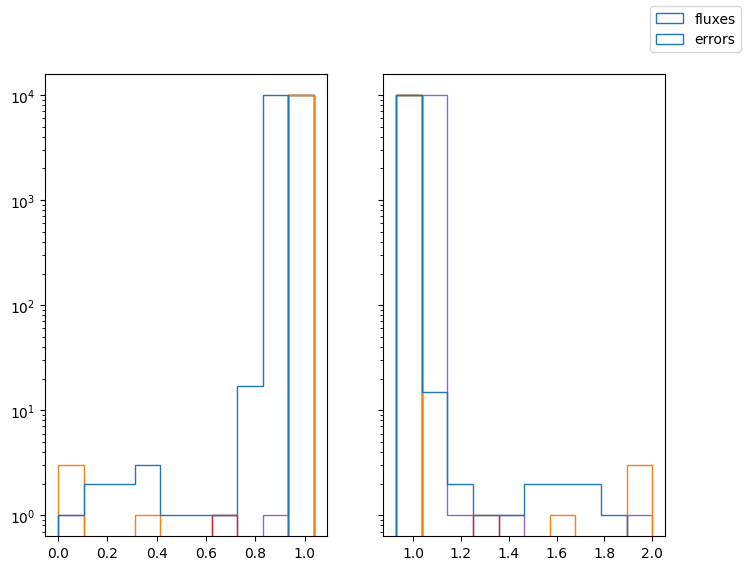

In [362]:
f_nu_k = 10**(-0.4*(m_k + 48.6))        # 'dirty' appmags -> 'dirty' f_nu in erg/s/Hz/cm^2

# from std error propagation
err_fnu = m_k_errs * 0.4 * np.log(10) * 10**(-0.4*(m_k + 48.6)) # from f_err**2 = |df/dm|**2 m_err**2 
err_fnu = err_fnu.rename(columns={"modelmag_u":"modelmagErr_u", "modelmag_g":"modelmagErr_g","modelmag_r":"modelmagErr_r","modelmag_i":"modelmagErr_i","modelmag_z":"modelmagErr_z"})

f_nu_kJ = f_nu_k * 10**32/3631 # transform to nanomaggies (3631 from Jy)
f_J = f_nu_kJ.rename(columns={"modelmag_g":"modelFlux_g", "modelmag_r":"modelFlux_r","modelmag_i":"modelFlux_i","modelmag_z":"modelFlux_z","modelmag_u":"modelFlux_u"})

err_fnuJ = err_fnu * 10**32/3631
fluxtest_err = np.sqrt(1/ivar_cat)
fluxtest_err = fluxtest_err.rename(columns={"modelFluxivar_g":"modelmagErr_g", "modelFluxivar_r":"modelmagErr_r",
                                            "modelFluxivar_i":"modelmagErr_i","modelFluxivar_z":"modelmagErr_z","modelFluxivar_u":"modelmagErr_u"})


fig, axs = plt.subplots(1,2, sharey=True)
axs[0].hist(fluxtest/f_J, log=True, histtype='step', label='fluxes') # flux test
axs[1].hist(fluxtest_err/err_fnuJ, log=True, histtype= 'step', label='errors') # error test
fig.legend()
fig.set_size_inches(8,6)
plt.show()

In [350]:
a = fluxtest_err/err_fnuJ

rows = a[a.columns].sum(axis=1)

mask = rows >= 8

a[mask]

,modelmagErr_u,modelmagErr_g,modelmagErr_r,modelmagErr_i,modelmagErr_z


In [351]:
inv_l = np.array((1/3540,1/4760,1/6280,1/7690,1/9250),dtype=float) # Query for SDSS constants (Angstorms)
inv_l = np.tile(inv_l, (x,1))

f_k = f_nu_k * c * inv_l            # 'dirty' f_nu -> 'dirty' flux or redshifted photometry
err_f = err_fnu * c * inv_l         # flux error

f_kJ = f_k * 10**29/3631            # micro Janskies for flux band
err_fJ = err_f * 10**29/3631        # micro Janskies for flux band error

'''f_kJ = fluxtest * 10**(-3) * c * inv_l
err_fJ = fluxtest_err * 10**(-3) * c * inv_l'''

f_kJ
err_fJ

,modelmagErr_u,modelmagErr_g,modelmagErr_r,modelmagErr_i,modelmagErr_z
0,5.080746e+11,2.315575e+11,2.908770e+11,3.632265e+11,8.887862e+11
1,5.720603e+11,2.483795e+11,2.718624e+11,3.247563e+11,8.263980e+11
2,5.074999e+11,1.976140e+11,2.533709e+11,3.160878e+11,8.485583e+11
3,4.848652e+11,2.138584e+11,2.657841e+11,3.026173e+11,7.611733e+11
4,7.069087e+11,3.143013e+11,4.045206e+11,4.662958e+11,1.148108e+12
...,...,...,...,...,...
9995,1.024367e+12,5.533407e+11,7.202373e+11,8.293916e+11,1.800435e+12
9996,6.080285e+11,2.541705e+11,3.276786e+11,3.773460e+11,1.108137e+12
9997,6.820039e+11,2.857749e+11,3.611161e+11,4.496429e+11,1.008794e+12
9998,1.402036e+12,8.601496e+11,7.921045e+11,1.380227e+12,2.360090e+12


# Kcorrect Test

In [366]:
# getting k correction values
responses = ['sdss_u0', 'sdss_g0','sdss_r0','sdss_i0','sdss_z0']
kz = kcorrect.kcorrect.Kcorrect(responses=responses, cosmo=cosmo)

maggies = f_nu_kJ * 10**(-9)            # we use fluxes from the catalog now that it's confirmed to be the same as ours                   
ivar = (err_fnuJ* 10**(-9))**-2

coeffs = kz.fit_coeffs(redshift=phot_reds, maggies=maggies, ivar=ivar)

K = kz.kcorrect(redshift=phot_reds, coeffs=coeffs)       # we have k values to clean out redshift effects from the appmag

M = kz.absmag(redshift=phot_reds, maggies=maggies, ivar=ivar, coeffs=coeffs) # works fine this time around: M = m -DM -K

derived = kz.derived(redshift=phot_reds, coeffs=coeffs)
stellar_mass = derived['mremain']

/home/yavuz/miniforge3/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1351: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


Manual calculation to test Absolute Magnitude

/tmp/ipykernel_10520/3430161304.py:6: RuntimeWarning: divide by zero encountered in log10
  stellar_massk = np.log10(stellar_mass.transpose())


(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.947e+03, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.947e+03, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 9.931e+03, 5.000e+00,
         4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00],
        [0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 9.933e+03, 7.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 9.945e+03, 1.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]]),
 array([-1445.53576974, -1122.49973724,  -799.46370474,  -476.42767223,
         -153.39163973,   169.64439277,   492.68042527,   815.71645778,
         1138.75249028,  1461.78852278,  1784.82455528]),
 <a list of 5 list[Polygon] objects>)

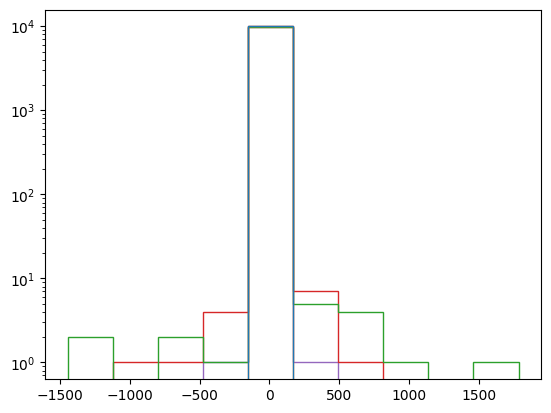

In [354]:
m_k_calc = m_k.to_numpy(dtype=float)
m_k_errs_calc = m_k_errs.to_numpy(dtype=float)
M_calc = m_k_calc - DM - K +0.85
M_calc_err = np.absolute(m_k_errs_calc - DM_err)

stellar_massk = np.log10(stellar_mass.transpose())
sm = sm.transpose()

M_r = M[:,2]
M_r_calc = M_calc[:,2]
absmagtest_r = absmagtest[:,2]
M_calc_err = M_calc_err[:,2]

delta_Mr = M_r_calc-absmagtest_r
delta_sm = sm - stellar_massk

plt.hist(K/k_corr_cat, log=True, histtype='step')

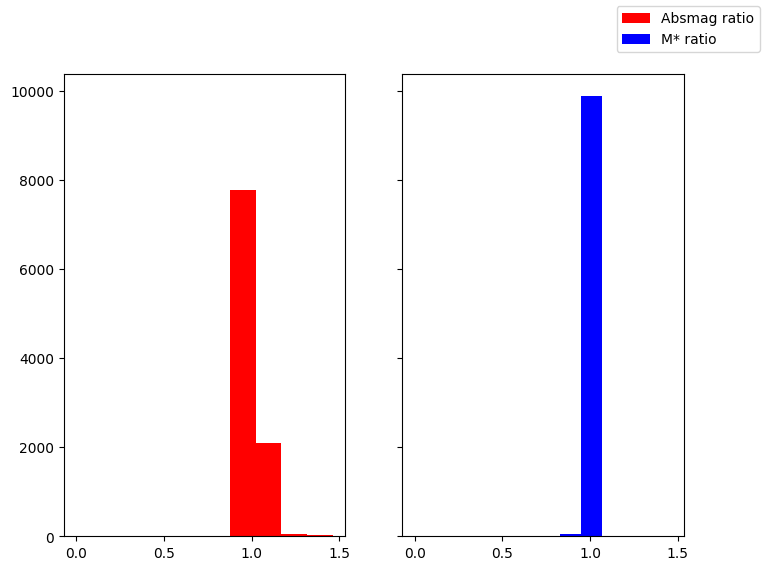

In [355]:
fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
ax[0].hist(absmagtest_r/M_r_calc, histtype='bar',label='Absmag ratio', color='r')
ax[1].hist(sm/stellar_massk, histtype='bar', label='M* ratio', color='b')
fig.set_size_inches(8,6)
fig.legend()

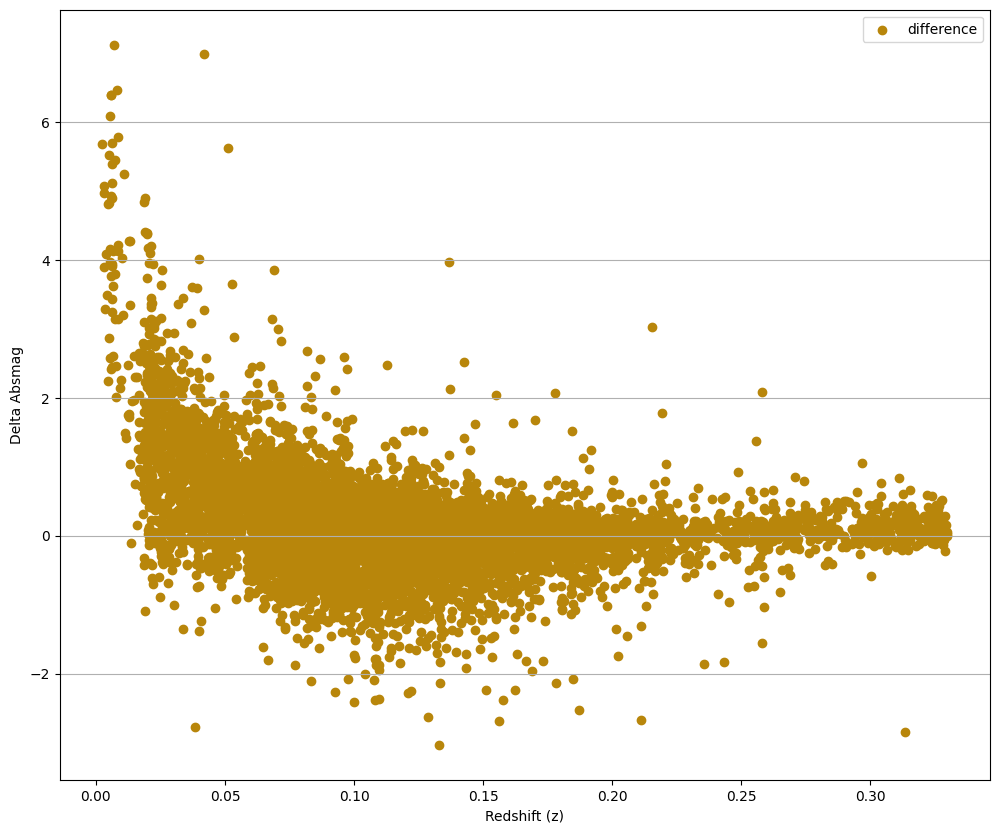

In [356]:
fig, ax = plt.subplots()
ax1 = ax.scatter(phot_reds, delta_Mr, c='darkgoldenrod', label='difference')

ax.legend()
ax.set_ylabel('Delta Absmag')
ax.set_xlabel('Redshift (z)')

ax.grid(axis='y')
fig.set_size_inches(12,10)
plt.show()

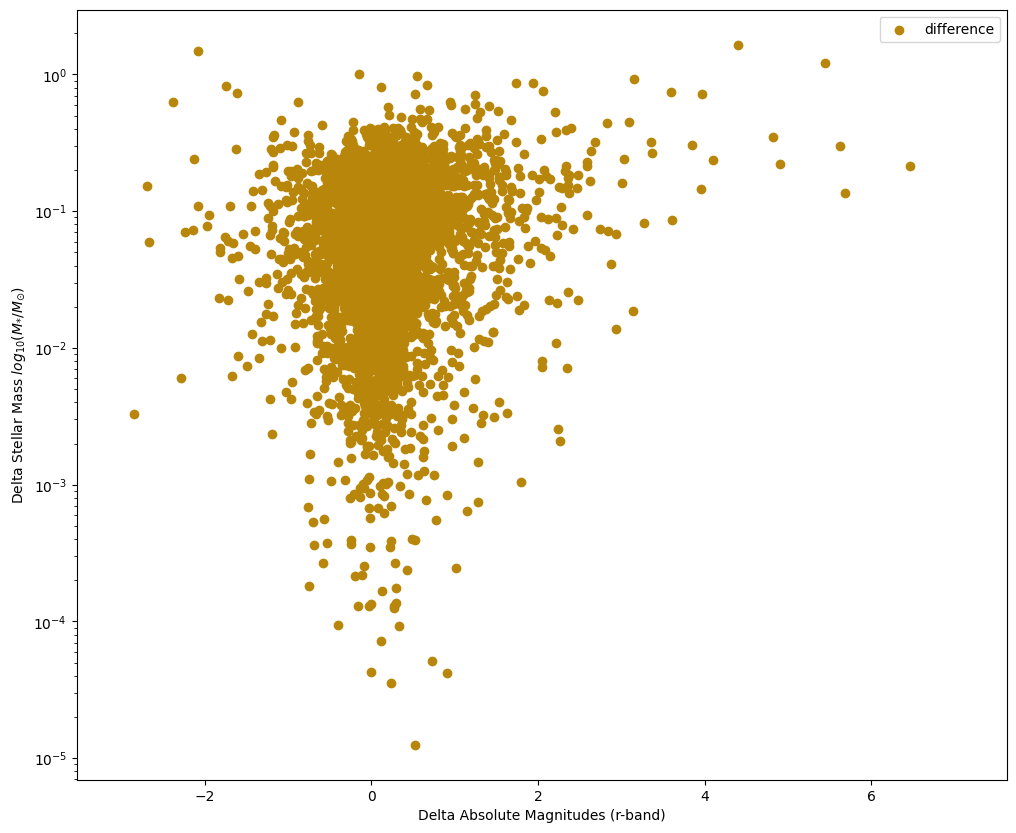

In [357]:
fig, ax = plt.subplots()
plt.scatter(delta_Mr, delta_sm, c='darkgoldenrod', label='difference')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Delta Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Delta Absolute Magnitudes (r-band)')

fig.set_size_inches(12,10)
plt.show()

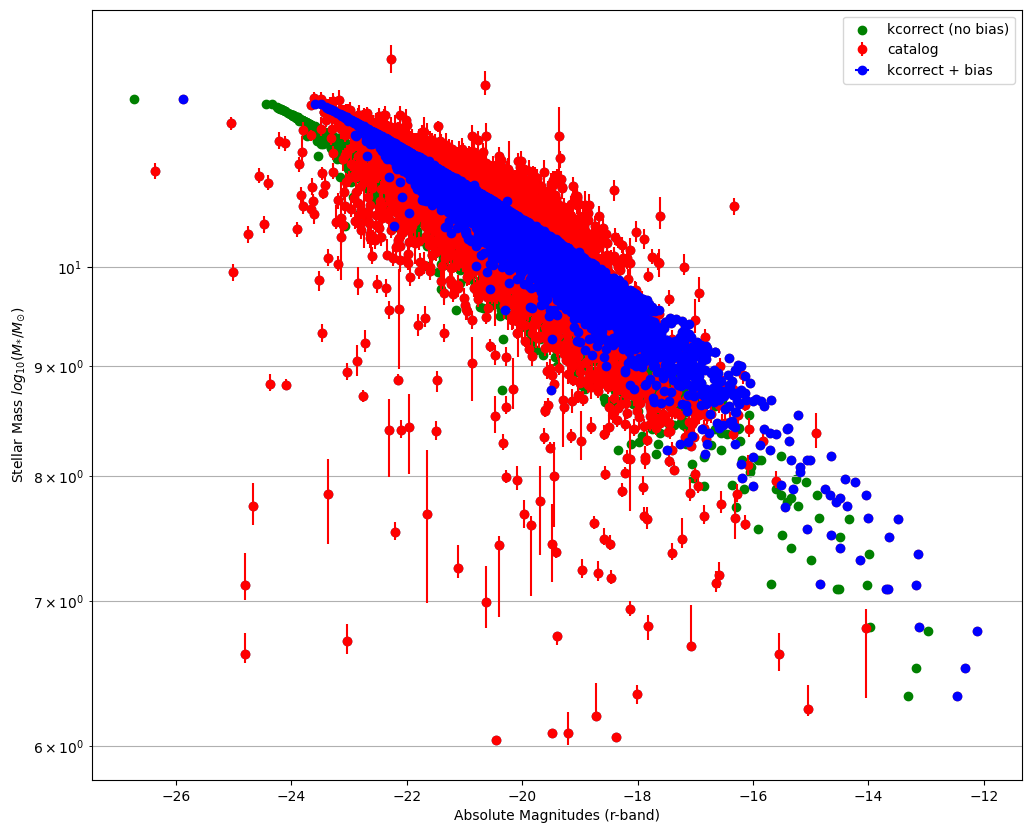

In [358]:
fig, ax = plt.subplots()
plt.scatter(absmagtest_r, sm)
plt.errorbar(absmagtest_r, sm, yerr=smtoterr,  fmt="o", c='r', label='catalog')
plt.scatter(M_r_calc, stellar_massk)
plt.errorbar(M_r_calc, stellar_massk, xerr=M_calc_err, fmt='o', c='b', label='kcorrect + bias')
plt.scatter(M_r, stellar_massk, marker='o', c='g', label='kcorrect (no bias)')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Absolute Magnitudes (r-band)')

ax.grid(axis='y',which='both')
fig.set_size_inches(12,10)
plt.show()

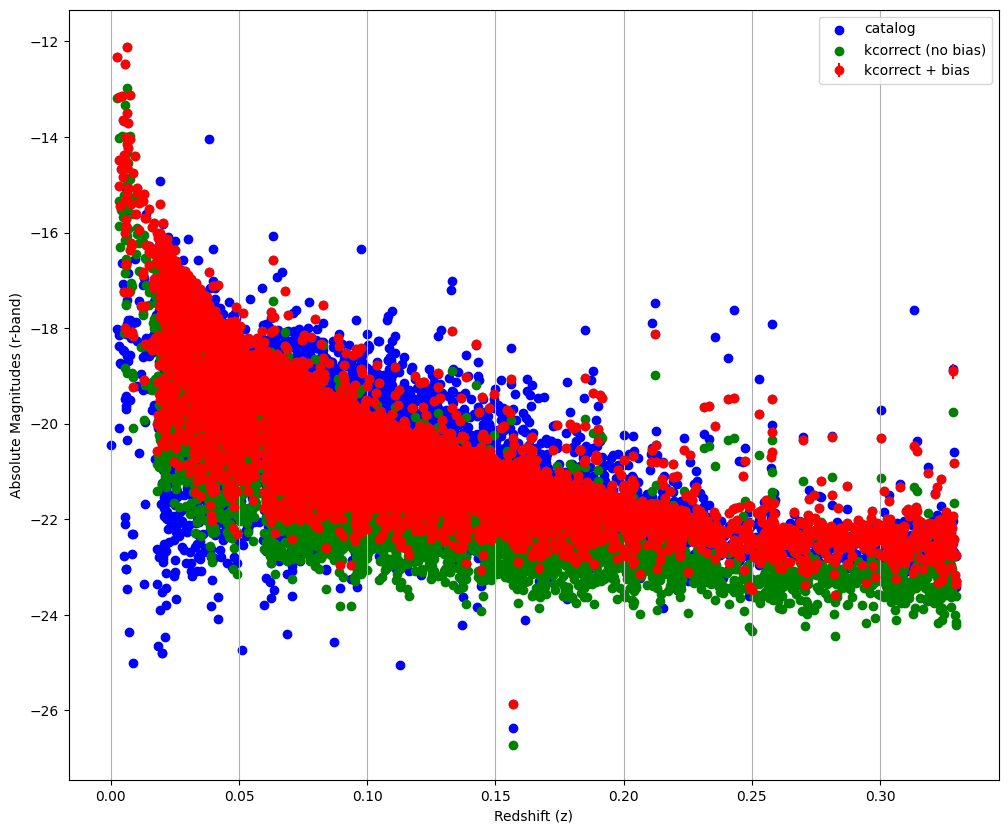

In [359]:
fig, ax = plt.subplots()

plt.scatter(phot_reds, absmagtest_r, marker="o", c='b', label='catalog')
plt.scatter(phot_reds, M_r_calc)
plt.errorbar(phot_reds, M_r_calc, yerr=M_calc_err, fmt='o', c='r', label='kcorrect + bias')
plt.scatter(phot_reds,M_r, marker='o', c='g', label='kcorrect (no bias)')

ax.set_yscale('linear')
ax.set_xscale('linear')

ax.legend()
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Absolute Magnitudes (r-band)')

ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()

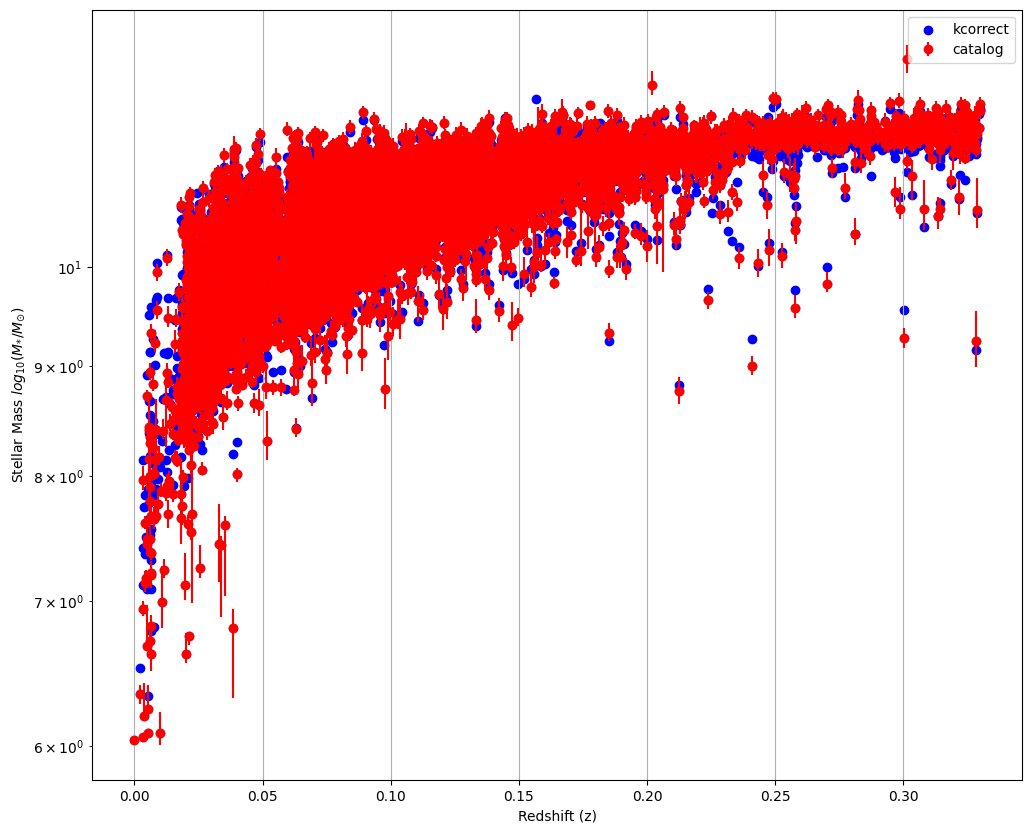

In [360]:
fig, ax = plt.subplots()
plt.scatter(phot_reds, sm)
plt.errorbar(phot_reds, sm, yerr=smtoterr, fmt="o", c='r', label='catalog')
ax1 = ax.scatter(phot_reds, stellar_massk, marker='o', c='b', label='kcorrect')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()

# Bagpipes test

In [35]:
# setup for galaxy fit
def photload(ID):
    # for "" and normal calling purposes (ID conversion)
    if ID in f_kJ.index:
        pass  # it's already the right type
    elif ID.isdigit() and int(ID) in f_kJ.index:
        ID = int(ID)
    else:
        raise KeyError(f"ID '{ID}' not found in catalog")

    # photometry array
    fluxes = f_kJ.loc[ID].values
    fluxerrs = err_fJ.loc[ID].values
    photometry = np.column_stack((fluxes, fluxerrs))

    # blow up the errors associated with any missing fluxes.
    for i in range(photometry.shape[0]):
        flux, err = photometry[i]
        if (flux == 0.) or (err <= 0):
            photometry[i] = [0., 9.9e99]

        # Cap the SNR
    for i in range(photometry.shape[0]):
        flux, err = photometry[i]
        max_snr = 30. if i < 2 else 15.  # or however you want to set it
        if flux / err > max_snr:
            photometry[i, 1] = flux / max_snr

    return photometry

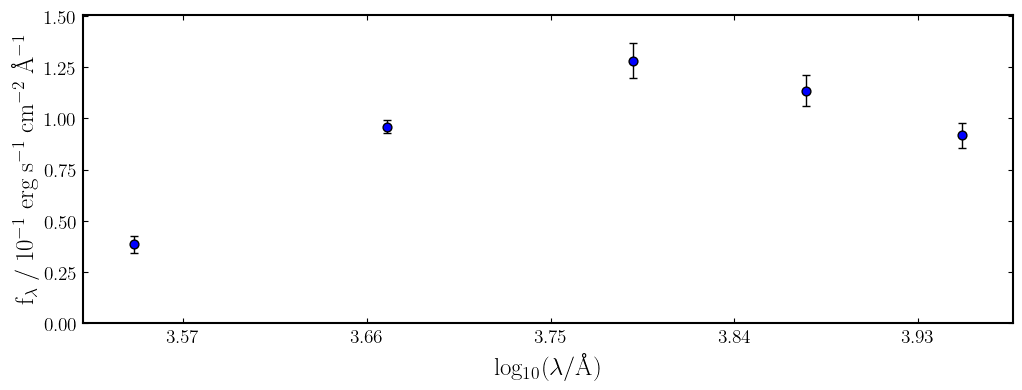


Bagpipes: fitting object 0

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            1  of mode            1  is converging towards the edge of the pr

/home/yavuz/miniforge3/lib/python3.10/site-packages/bagpipes/models/model_galaxy.py:559: RuntimeWarning: invalid value encountered in log10
  self.uvj = -2.5*np.log10(self._calculate_photometry(0., uvj=True))


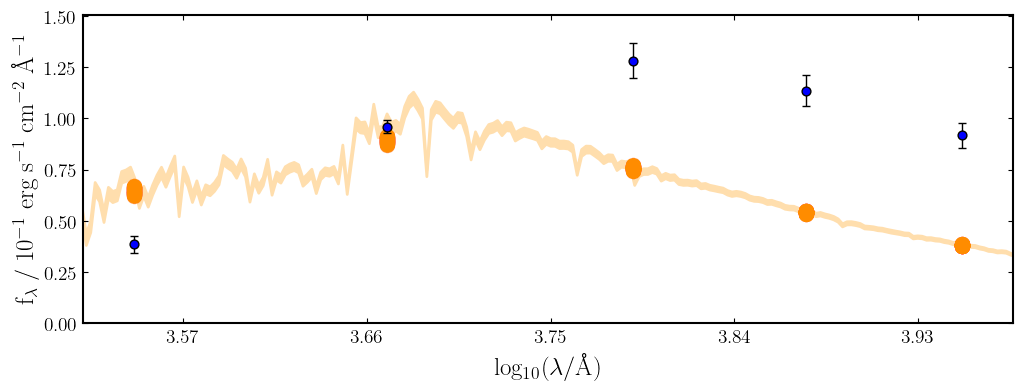

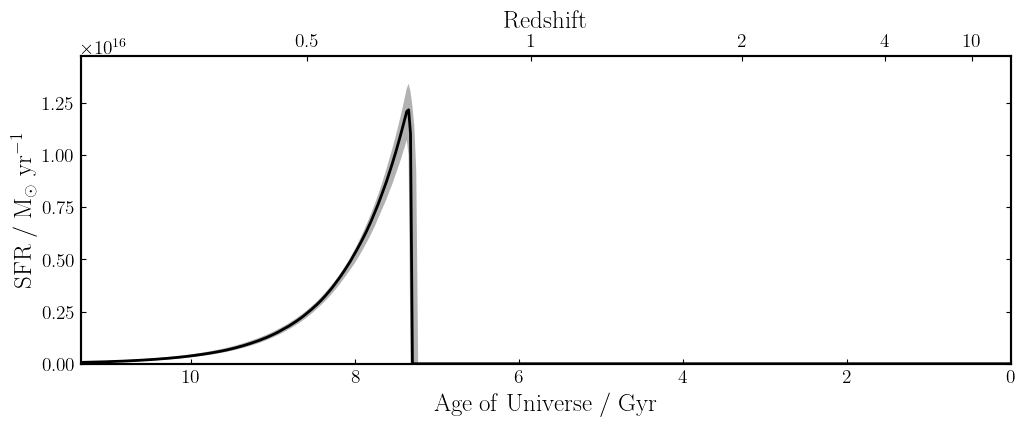

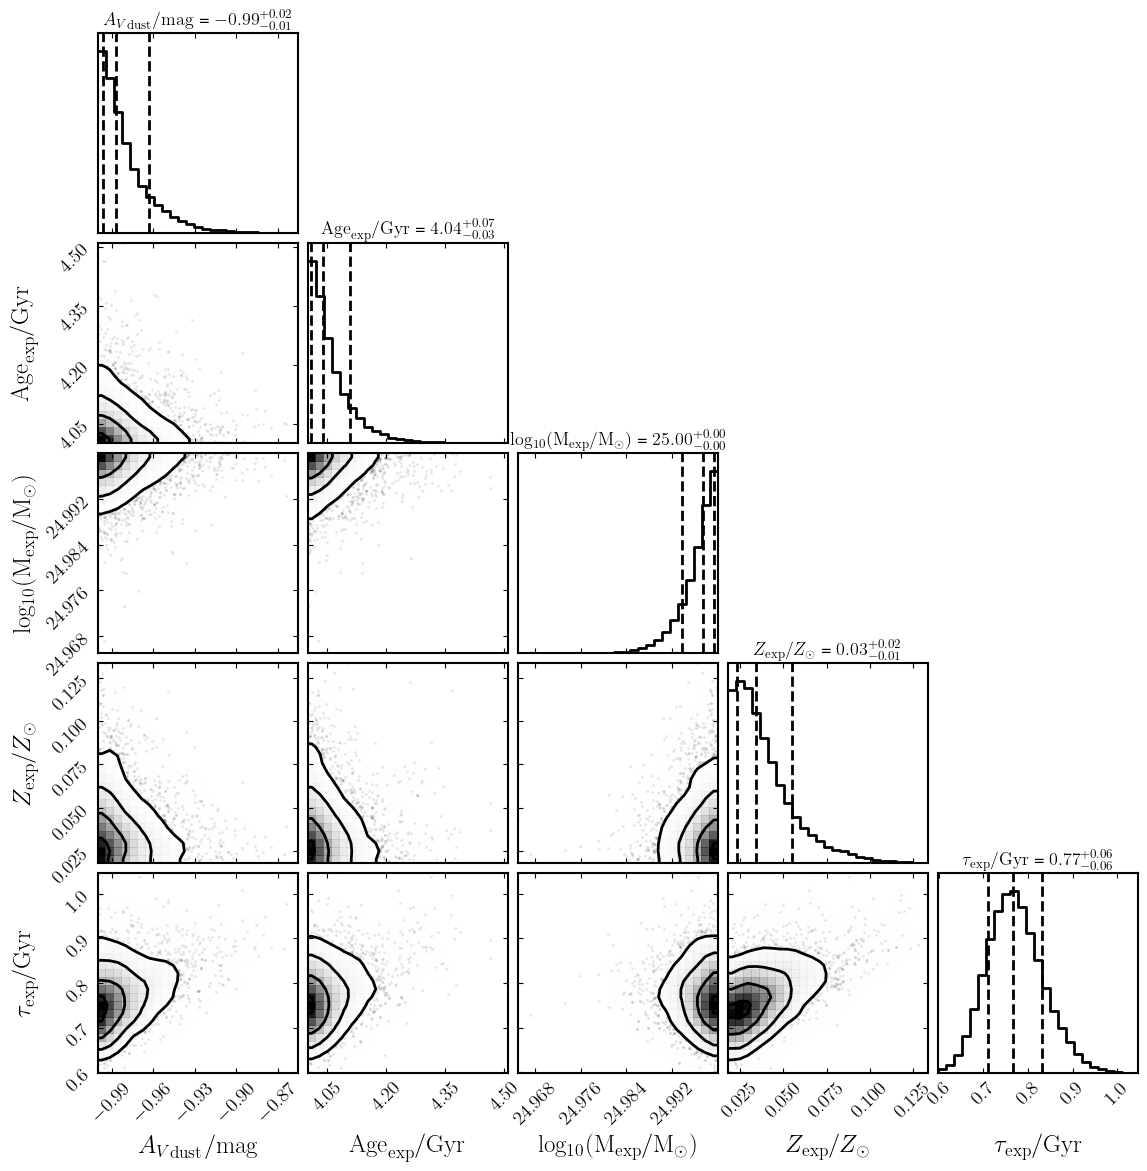

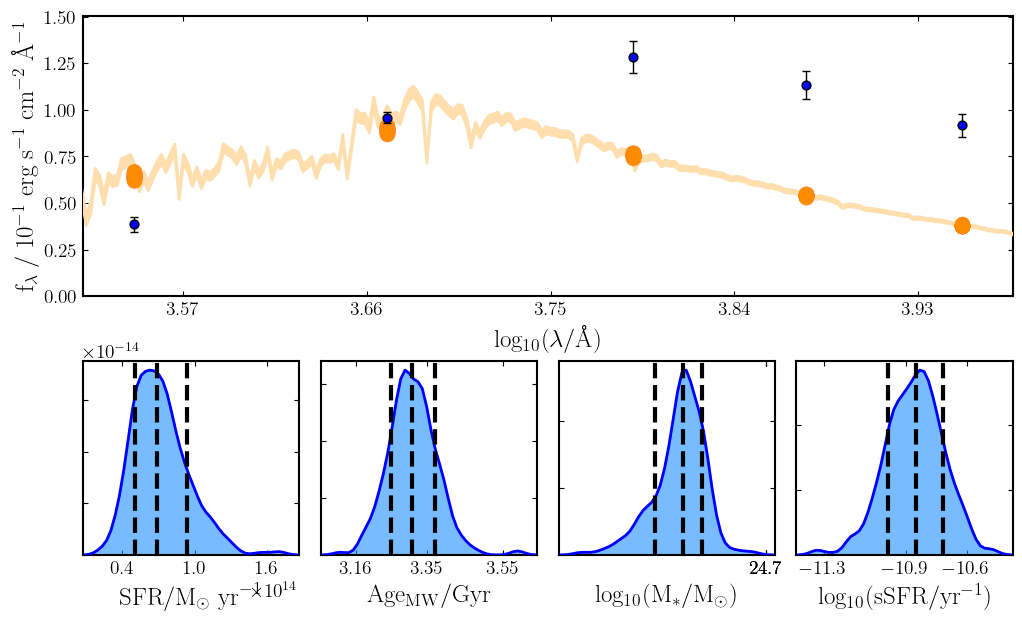

24.688348202990163


In [ ]:
filt_list = np.loadtxt("/home/yavuz/miniforge3/lib/python3.10/site-packages/bagpipes/filters/sdss_filt_list.txt", dtype="str")

for i in range (0,1):
    galaxy = pp.galaxy('0', photload, spectrum_exists=False, filt_list=filt_list)
    fig = galaxy.plot()

    #fit instructions dict.
    exp = {}                                  # Tau-model star-formation history component
    exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                              # the code automatically limits this to the age of
                                              # the Universe at the observed redshift.

    exp["tau"] = (0.01, 13.)                  # Vary tau between 10 Myr and 13 Gyr
    exp["massformed"] = (5., 25.)             # vary log_10(M*/M_solar) between 1 and 15
    exp["metallicity"] = (-1., 8)              # vary Z between 0 and 5 Z_oldsolar

    dust = {}                                 # Dust component
    dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
    dust["Av"] = (0., 5.)                     # Vary Av between 0 and 5 magnitudes

    fit_instructions = {}                     # The fit instructions dictionary
    fit_instructions["redshift"] = 0.192828   # Vary observed redshift from 0 to 2
    fit_instructions["exponential"] = exp   
    fit_instructions["dust"] = dust
        
    #fitting galaxy
    fit = pp.fit(galaxy, fit_instructions)

    fit.fit(verbose=False)

    # photometry fitting & plots
    fig = fit.plot_spectrum_posterior(save=False, show=False)
    fig = fit.plot_sfh_posterior(save=False, show=False)
    fig = fit.plot_corner(save=False, show=True)

    # selective plots
    fig = plt.figure(figsize=(12, 7))
    gs = mpl.gridspec.GridSpec(7, 4, hspace=3., wspace=0.1)

    ax1 = plt.subplot(gs[:4, :])

    pp.plotting.add_observed_photometry(fit.galaxy, ax1, zorder=10)
    pp.plotting.add_photometry_posterior(fit, ax1)

    labels = ["sfr", "mass_weighted_age", "stellar_mass", "ssfr"]

    post_quantities = dict(zip(labels, [fit.posterior.samples[l] for l in labels]))

    axes = []
    for i in range(4):
        axes.append(plt.subplot(gs[4:, i]))
        pp.plotting.hist1d(post_quantities[labels[i]], axes[-1], smooth=True, label=labels[i])

    plt.show()
    '''f = open('/home/yavuz/Desktop/MT/pp_sm.txt','a')
    print(np.median(fit.posterior.samples["stellar_mass"]), file=f)
    g = open('/home/yavuz/Desktop/MT/reds_pp.txt','a')
    print(np.median(fit.posterior.samples["redshift"]), file=g)'''

    print(np.median(fit.posterior.samples["stellar_mass"]))
    '''print(np.median(fit.posterior.samples["redshift"]))'''

# Comparison for both

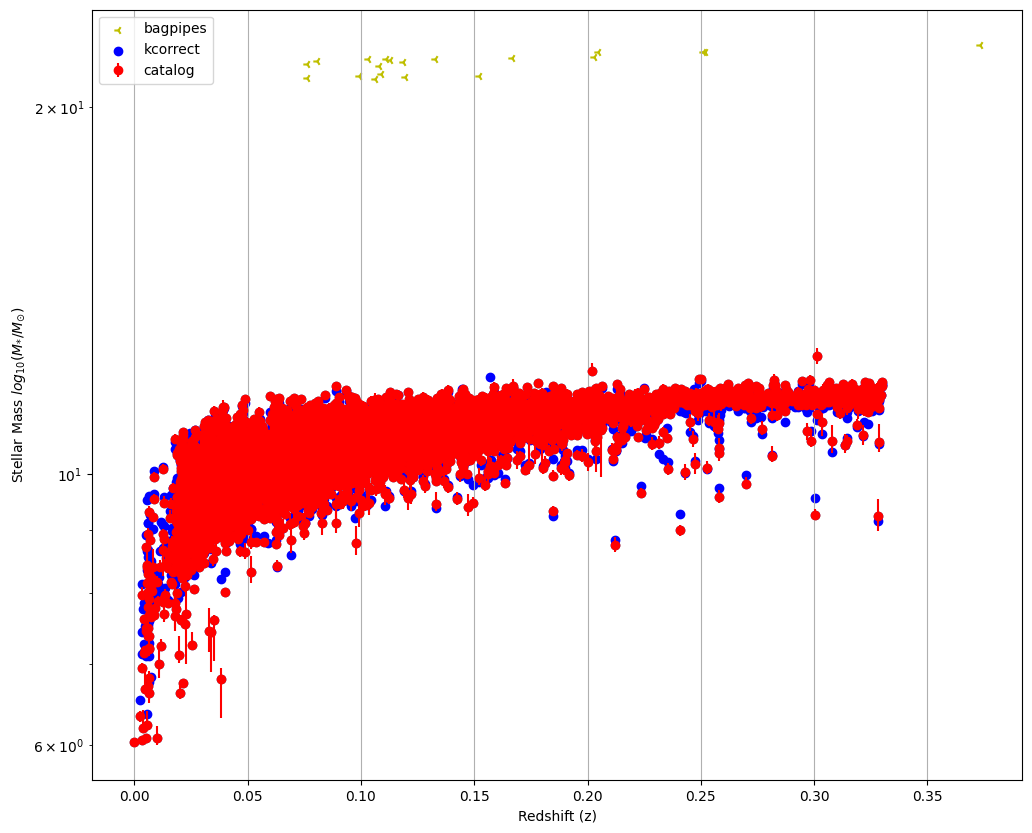

In [237]:
sm_pp = np.loadtxt('/home/yavuz/Desktop/MT/pp_sm.txt')
z_pp = np.loadtxt('/home/yavuz/Desktop/MT/reds_pp.txt')

fig, ax = plt.subplots()
ax2 = ax.scatter(z_pp, sm_pp,marker='3', c='y', label='bagpipes')
plt.scatter(phot_reds, sm)
plt.errorbar(phot_reds, sm, yerr= smtoterr, fmt='o', c='red', label='catalog')
plt.scatter(phot_reds, stellar_massk, c='b', label='kcorrect')

ax.set_xscale('linear')
ax.set_yscale('log')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()